In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [ ]:
# image path
path = '/content/drive/MyDrive/Colab Notebooks/BEP/Image'
original = path + '/Original.png'
uniform = path + '/Uniform_noise.png'
salt_and_pepper = path + '/salt_and_pepper.ppm'
gaussian = path + '/Gaussian_noise.ppm'
black = path + '/img1.png'
white = path + '/img2.png'
img3 = path + '/img3.png'

In [ ]:
def img_resize(img, size=256):
    image = cv.resize(img, (size,size), interpolation=cv.INTER_LINEAR)
    return image

def imshow(before, after):
    imgs = np.array([before, after])
    pltsize = 5
    plt.figure(figsize=(2 * pltsize, pltsize))

    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.axis('off')
        plt.imshow(imgs[i], cmap='gray')
        im_shape = str(imgs[i].shape)
        plt.title('img shape : ' + im_shape)
    plt.show()

In [ ]:
# 이미지 불러오기
# 이미지1
imgo = img_resize(cv.imread(original, cv.IMREAD_GRAYSCALE))             # 원본 이미지
imgu = img_resize(cv.imread(uniform, cv.IMREAD_GRAYSCALE))              # 노이즈 : Uniform
imgs = img_resize(cv.imread(salt_and_pepper, cv.IMREAD_GRAYSCALE))      # 노이즈 : Salt_and_pepper
imgg = img_resize(cv.imread(gaussian, cv.IMREAD_GRAYSCALE))             # 노이즈 : gaussian

# 이미지2
imgb = img_resize(cv.imread(black, cv.IMREAD_GRAYSCALE))                # 노이즈 : 검은 선 
imgw = img_resize(cv.imread(white, cv.IMREAD_GRAYSCALE))                # 노이즈 : 흰색 선 
img33 = img_resize(cv.imread(img3, cv.IMREAD_GRAYSCALE))                # 노이즈 : 특정 주파수

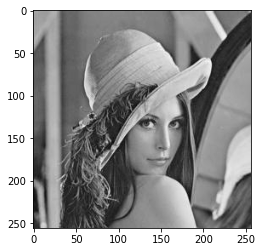

In [29]:
plt.imshow(imgo, 'gray')

# Padding

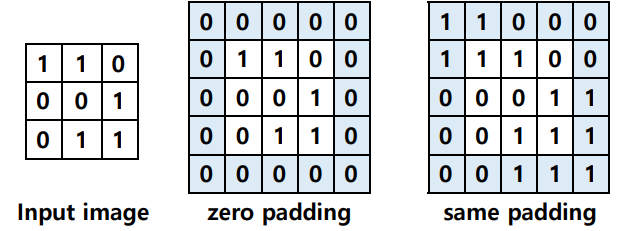

## code

In [ ]:
# image padding
def zero_padding(img, pad = 0):
    c, r = img.shape
    zero_pad = np.zeros((c + pad*2, r + pad*2)).astype(int)
    for i in range(c):
        zero_pad[i+pad][pad:-pad] = img[i]
    imshow(img, zero_pad)
    return zero_pad

def same_padding(img, pad = 0):
    c, r = img.shape
    egcopy_pad = np.zeros((c + pad*2, r + pad*2)).astype(int)
    for i in range(c):
        egcopy_pad[i+pad][pad:-pad] = img[i]

    for i in range(pad):
        egcopy_pad[i] = egcopy_pad[pad]
        egcopy_pad[-(i+1)] = egcopy_pad[-(pad+1)]
        egcopy_pad = egcopy_pad.T; img = img.T
        egcopy_pad[i] = egcopy_pad[pad]
        egcopy_pad[-(i+1)] = egcopy_pad[-(pad+1)]
        egcopy_pad = egcopy_pad.T; img = img.T
        
    imshow(img, egcopy_pad)
    return egcopy_pad

def mirror_padding(img, pad = 0):
    c, r = img.shape
    mirror_pad = np.zeros((c + pad*2, r + pad*2)).astype(int)
    for i in range(c):
        mirror_pad[i+pad][pad:-pad] = img[i]

    for i in range(pad):
        mirror_pad[i] = mirror_pad[pad*2-i]
        mirror_pad[-(i+1)] = mirror_pad[-(pad*2-i+1)]
        mirror_pad = mirror_pad.T; img = img.T
        mirror_pad[i] = mirror_pad[pad*2-i]
        mirror_pad[-(i+1)] = mirror_pad[-(pad*2-i+1)]
        mirror_pad = mirror_pad.T; img = img.T
        
    imshow(img, mirror_pad)
    return mirror_pad

## results

 zero_padding 


<ipython-input-4-8bee2704cf17>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgs = np.array([before, after])


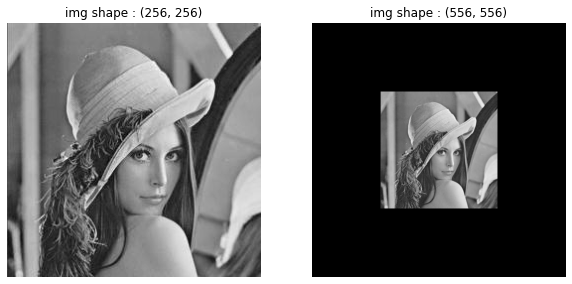

 same_padding 


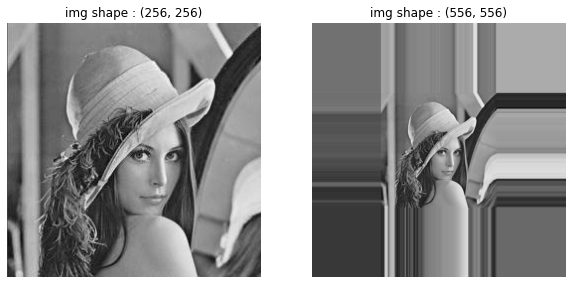

 Mirror_padding 


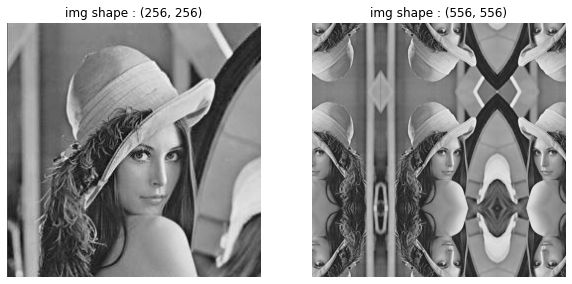

array([[127, 129, 133, ...,  39, 104, 204],
       [128, 130, 135, ...,  49, 209, 182],
       [128, 131, 136, ..., 159, 206, 188],
       ...,
       [174, 177, 174, ...,  45,  56,  81],
       [178, 176, 168, ...,  53,  43,  65],
       [175, 175, 173, ...,  47,  48,  50]])

In [30]:
pad_size = 150
print('==================================')
print(' zero_padding ')
zero_padding(imgo, pad_size)
print('==================================')
print(' same_padding ')
same_padding(imgo, pad_size)
print('==================================')
print(' Mirror_padding ')
mirror_padding(imgo, pad_size)

# Convolution 연산 및 pooling

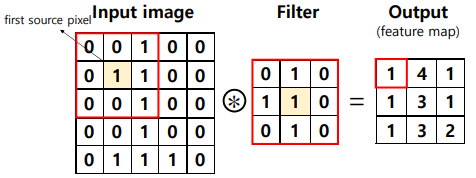
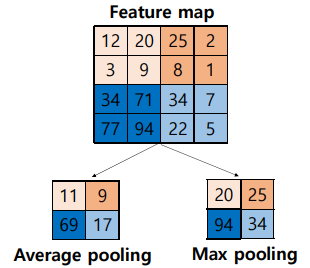

## code

In [ ]:
def convolution(img, filter, stride):
    c, r = img.shape
    filter_size = filter.shape[0]
    nc = int((c-filter_size)/stride + 1)  # ==> output size 계산
    nr = int((r-filter_size)/stride + 1)
    output = np.zeros([nc, nr])
    ncol = 0
    for i in range(0, r - filter_size + 1, stride): # ==> y 축 이동
        nrow = 0
        for j in range(0, c - filter_size + 1, stride):  # ==> x 축 이동
            SUM = 0
            for k in range(filter_size):  # ==> element wise multiplication
                SUM += img[i+k][j:j+filter_size].dot(filter.T[k])   
            output[ncol][nrow] = SUM
            nrow += 1
        ncol += 1
    return output


def Sobel_detection(img, stride=1, mode=0):
    filter_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
    filter_y = filter_x.T
    output1 = convolution(img, filter_x, stride)
    output2 = convolution(img, filter_y, stride)
    output = np.sqrt(output1*output1 + output2*output2)
    if mode == 0:
        imshow(img, output)
    elif mode == 1:
        return output, output1, output2

def Average_pooling(img, mode=0, filter_size=2):
    filter = np.ones((filter_size, filter_size))/(filter_size**2)
    output = convolution(img, filter, 2)
    if mode == 0:
        imshow(img, output)
    elif mode == 1:
        return output 

## results

<ipython-input-4-8bee2704cf17>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgs = np.array([before, after])


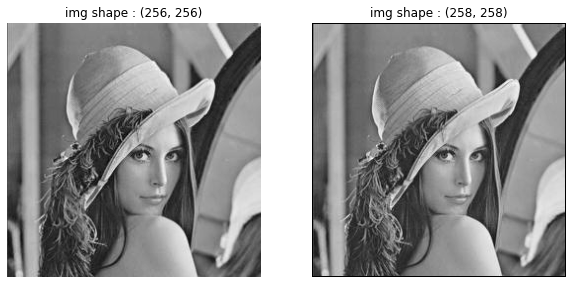


===== Sobel_detection =====


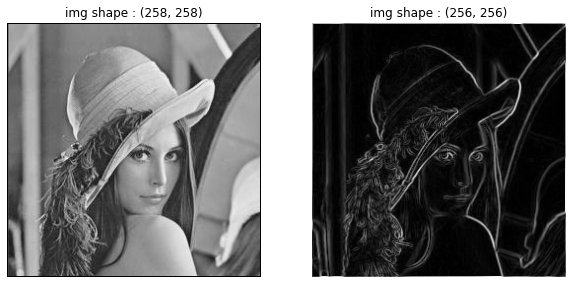


===== Average pooling =====


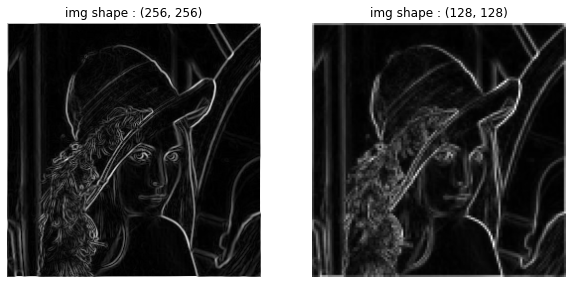

In [ ]:
img = zero_padding(imgo, 1)
print('\n===== Sobel_detection =====')
output, _, _ = Sobel_detection(img, mode=1)
imshow(img, output)

print('\n===== Average pooling =====')
Average_pooling(output, filter_size = 2)

# Sort

In [ ]:
# Sort
# Selection Sort는 첫번째 인덱스 부터 시작해서 더 작은 값이 있는 인덱스와 바꿔 가며 정렬하는 방법
def selectionSort(arr, order = 0):
    n = len(arr)                       
    for i in range(n - 1):
        minIdx = i                     
        for k in range( i + 1, n ):     
            if order == 0:
                if (arr[minIdx] > arr[k]) : 
                    minIdx = k              
            elif order == 1:
                if (arr[minIdx] < arr[k]) : 
                    minIdx = k              
        tmp = arr[i]                    
        arr[i] = arr[minIdx]            
        arr[minIdx] = tmp       

    return arr

# Filters

## code

In [ ]:
# Filter
def Average_filter(img, mask = 3, stride = 1):
    filter = np.ones([mask, mask])/mask**2
    output = convolution(img, filter, stride)
    imshow(img, output)

def Median_filter(img, mask = 3, stride = 1):
    filter = np.ones([mask, mask])/mask**2
    c, r = img.shape
    nc = int((c-mask)/stride + 1)
    nr = int((r-mask)/stride + 1)
    output = np.zeros([nc, nr])
    ncol = 0
    for i in range(0, c - mask + 1, stride):
        nrow = 0
        for j in range(0, r - mask + 1, stride):
            mat = [0]*(mask**2)
            count = 0
            for k in range(mask):
                for l in range(mask):
                    mat[count] += img[i+k][j+l]
                    count+=1
            Median_index = int((mask**2)/2)       # ==> Median index 계산 : int(9/2) = 4
            Selection_sort = selectionSort(mat)   # ==> filter 내 픽셀값 정렬
            output[ncol][nrow] = Selection_sort[Median_index] # median 값 선택 후 저장
            nrow += 1
        ncol += 1
    imshow(img, output)

def Maximum_filter(img, mask = 3, stride = 1):
    filter = np.ones([mask, mask])/mask**2
    c, r = img.shape
    nc = int((c-mask)/stride + 1)
    nr = int((r-mask)/stride + 1)
    output = np.zeros([nc, nr])
    ncol = 0
    for i in range(0, c - mask + 1, stride):
        nrow = 0
        for j in range(0, r - mask + 1, stride):
            mat = [0]*(mask**2)
            count = 0
            for k in range(mask):
                for l in range(mask):
                    mat[count] += img[i+k][j+l]
                    count+=1
            Maximum_index = mask**2 - 1         # Maximum_index 계산
            Selection_sort = selectionSort(mat) # ==> filter 내 픽셀값 정렬
            output[ncol][nrow] = Selection_sort[Maximum_index]  # Maximum 값 선택 후 저장
            nrow += 1
        ncol += 1
    imshow(img, output)

def Minimum_filter(img, mask = 3, stride = 1):
    filter = np.ones([mask, mask])/mask**2
    c, r = img.shape
    nc = int((c-mask)/stride + 1)
    nr = int((r-mask)/stride + 1)
    output = np.zeros([nc, nr])
    ncol = 0
    for i in range(0, c - mask + 1, stride):
        nrow = 0
        for j in range(0, r - mask + 1, stride):
            mat = [0]*(mask**2)
            count = 0
            for k in range(mask):
                for l in range(mask):
                    mat[count] += img[i+k][j+l]
                    count+=1
            Minimum_index = 0       # Minimum index 선택
            Selection_sort = selectionSort(mat) # ==> filter 내 픽셀값 정렬
            output[ncol][nrow] = Selection_sort[Minimum_index]  # Minimum 값 선택 후 저장
            nrow += 1
        ncol += 1
    imshow(img, output)

def Midpoint_filter(img, mask = 3, stride = 1):
    filter = np.ones([mask, mask])/mask**2
    c, r = img.shape
    nc = int((c-mask)/stride + 1)
    nr = int((r-mask)/stride + 1)
    output = np.zeros([nc, nr])
    ncol = 0
    for i in range(0, c - mask + 1, stride):
        nrow = 0
        for j in range(0, r - mask + 1, stride):
            mat = [0]*(mask**2)
            count = 0
            for k in range(mask):
                for l in range(mask):
                    mat[count] += img[i+k][j+l]
                    count+=1
            Selection_sort = selectionSort(mat) # ==> filter 내 픽셀값 정렬
            Mid_value = (Selection_sort[0] + Selection_sort[int(mask**2 - 1)])/2    # minimum값과 maximum값을 뽑아 평균값 계산 
            output[ncol][nrow] = Mid_value  # 계산 후 저장
            nrow += 1
        ncol += 1
    imshow(img, output)

def Alpha_trimmed_filter(img, mask = 3, stride = 1, alpha = 0):
    filter = np.ones([mask, mask])/mask**2
    c, r = img.shape
    nc = int((c-mask)/stride + 1)
    nr = int((r-mask)/stride + 1)
    output = np.zeros([nc, nr])
    ncol = 0
    for i in range(0, c - mask + 1, stride):
        nrow = 0
        for j in range(0, r - mask + 1, stride):
            mat = [0]*(mask**2)
            count = 0
            for k in range(mask):
                for l in range(mask):
                    mat[count] += img[i+k][j+l]
                    count+=1
            Selection_sort = selectionSort(mat) # ==> filter 내 픽셀값 정렬
            alpha_idx = int((mask**2)*alpha)    # 가장자리로 부터 제외할 픽셀 인덱스 계산
            alpha_mean_value = np.mean(mat[alpha_idx:-alpha_idx])   # 가장자리로 부터 알파 값의 비율만큼 픽셀값을 제거한 후 나머지 값으로 평균값 계산
            output[ncol][nrow] = alpha_mean_value   # 계산 후 저장
            nrow += 1
        ncol += 1
    imshow(img, output)


## results

<ipython-input-4-8bee2704cf17>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgs = np.array([before, after])


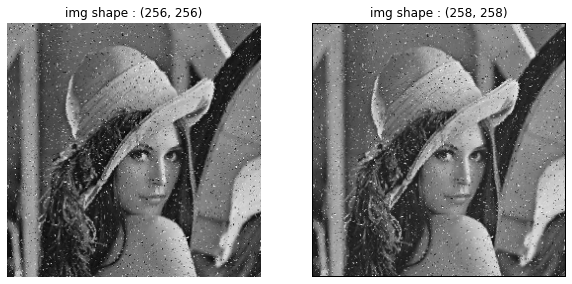


===== Average_filter =====


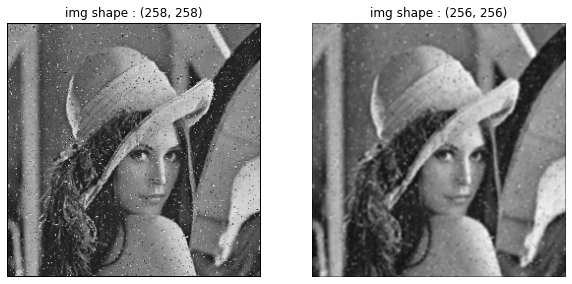


===== Median_filter =====


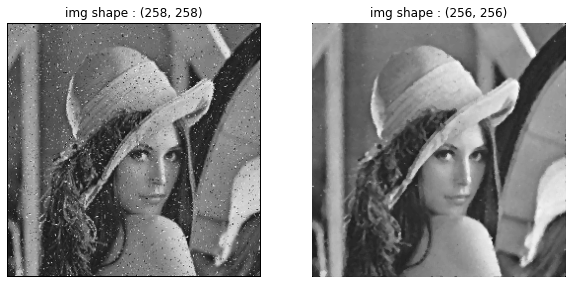


===== Maximum_filter =====


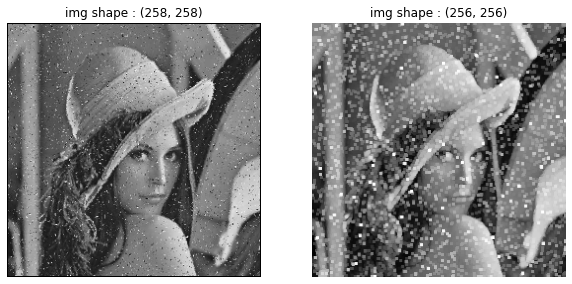


===== Minimum_filter =====


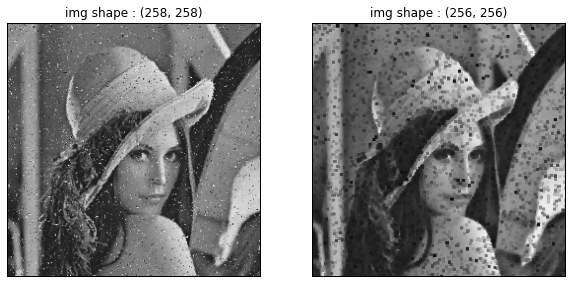


===== Midpoint_filter =====


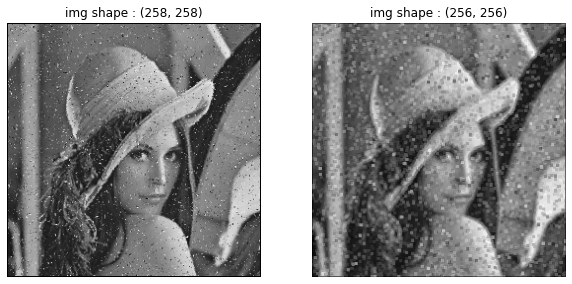


===== Alpha_trimmed_filter =====


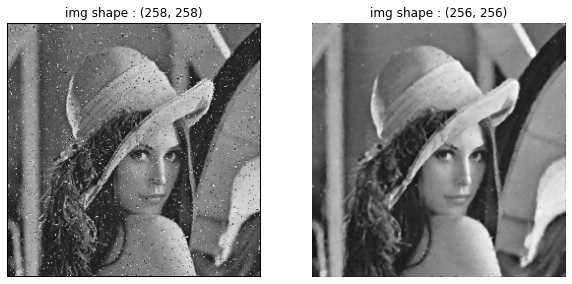

In [ ]:
#zero_padding에 imgb, imgw, img33, imgu, imgg, imgs 중 하나 입력 
img = zero_padding(imgs, 1)
filter_size = 3
print('\n===== Average_filter =====')
Average_filter(img, filter_size)
print('\n===== Median_filter =====')
Median_filter(img, filter_size)
print('\n===== Maximum_filter =====')
Maximum_filter(img, filter_size)
print('\n===== Minimum_filter =====')
Minimum_filter(img, filter_size)
print('\n===== Midpoint_filter =====')
Midpoint_filter(img, filter_size)
print('\n===== Alpha_trimmed_filter =====')
Alpha_trimmed_filter(img, filter_size, alpha=0.4)

# Edge detection

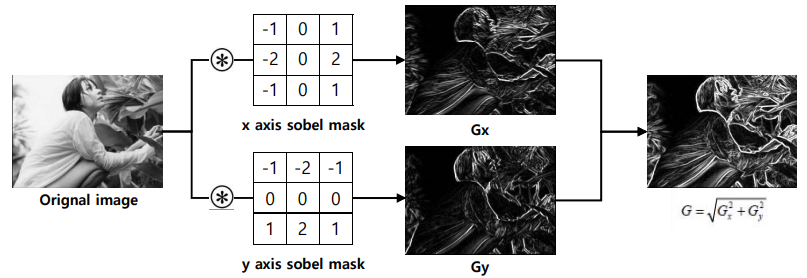

In [ ]:
# Edge : edge는 영상안에 있는 객체의 경계(boundary)를 가리키는 것으로서, 
# 모양(shape), 방향성(direction)을 탐지할 수 있는 등 여러 정보가 담겨있다.

def Sobel_detection(img, stride=1, mode=0):
    filter_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
    filter_y = np.array([[-1, -2, -1],
                        [0, 0, 0],
                        [1, 2, 1]])
    Gx = convolution(img, filter_x, stride)
    Gy = convolution(img, filter_y, stride)
    output = np.sqrt(Gx*Gx + Gy*Gy)
    if mode == 0:
        imshow(img, output)
    elif mode == 1:
        return output, Gx, Gy


<ipython-input-4-8bee2704cf17>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgs = np.array([before, after])


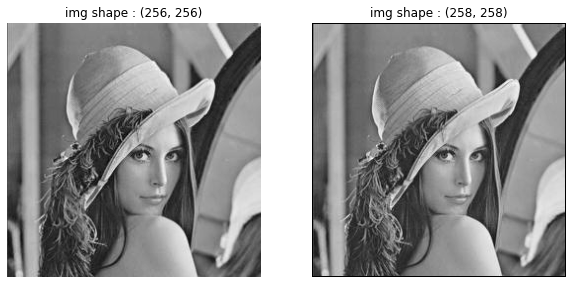


===== Sobel_detection =====


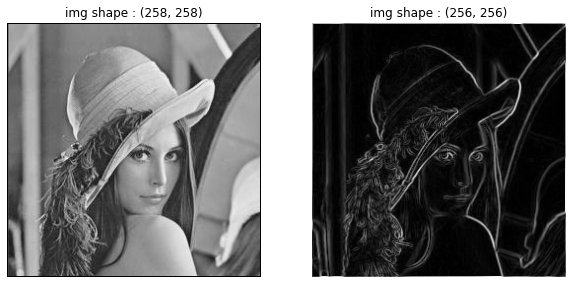

In [ ]:
img = zero_padding(imgo, 1)
print('\n===== Sobel_detection =====')
Sobel_detection(img)

# Code practice

- Edge Detection 알고리즘 3종류, Gaussian filter 적용해서 이미지로 출력해보기
1. Prewitt detection 
2. Roberts detection 
3. Gaussian filter 
    - Gaussian filter는 강의자료에 있는 filter 값 사용하시면 됩니다.
4. Log detection 

In [ ]:
def _detection(img, stride=1, mode=0):
    filter_x = np.array([])
    filter_y = np.array([])
    Gx = convolution(img, filter_x, stride)
    Gy = convolution(img, filter_y, stride)
    output = np.sqrt(Gx*Gx + Gy*Gy)
    if mode == 0:
        imshow(img, output)
    elif mode == 1:
        return output, Gx, Gy